# Training

---
# 📦 Section 1: Setup & Configuration

First, let's set up our environment and create a shared configuration system that allows us to easily compare different models and training strategies.

In [53]:
# Essential imports for deep learning and visualization
import os
import time
import random
import json
from pathlib import Path
from typing import Dict, Any, List, Optional, Tuple
from dataclasses import dataclass, field, asdict
from datetime import datetime

# Scientific computing and visualization
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import cv2
from PIL import Image

# Deep learning frameworks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler

# HuggingFace Transformers for SegFormer
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor

# Progress tracking
from tqdm.notebook import tqdm

In [54]:
# Check if running in Google Colab
import sys
COLAB = 'google.colab' in sys.modules
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    PATH = "drive/MyDrive/EGH444/datasets/NYUDepthv2"

## 🎛️ Shared Configuration System

Let's create a comprehensive configuration system that allows us to easily switch between different experimental setups. This approach ensures reproducibility and makes it easy to compare different models.

In [55]:
@dataclass
class TrainingHistory:
    """Tracks comprehensive training metrics for analysis and visualization."""
    
    # Training metrics (per epoch)
    train_loss: List[float] = field(default_factory=list)
    train_miou: List[float] = field(default_factory=list)
    train_pixacc: List[float] = field(default_factory=list)
    
    # Validation metrics (per epoch)
    val_loss: List[float] = field(default_factory=list)
    val_miou: List[float] = field(default_factory=list)
    val_pixacc: List[float] = field(default_factory=list)
    
    # Training metadata
    learning_rates: List[float] = field(default_factory=list)
    epoch_times: List[float] = field(default_factory=list)
    
    def add_epoch(self, epoch_data: Dict[str, float]) -> None:
        """Add metrics for a completed epoch."""
        self.train_loss.append(epoch_data.get("train_loss", 0.0))
        self.train_miou.append(epoch_data.get("train_miou", 0.0))
        self.train_pixacc.append(epoch_data.get("train_pixacc", 0.0))
        
        self.val_loss.append(epoch_data.get("val_loss", 0.0))
        self.val_miou.append(epoch_data.get("val_miou", 0.0))
        self.val_pixacc.append(epoch_data.get("val_pixacc", 0.0))
        
        self.learning_rates.append(epoch_data.get("learning_rate", 0.0))
        self.epoch_times.append(epoch_data.get("epoch_time", 0.0))
    
    def get_best_epoch(self, metric: str = "val_miou") -> Tuple[int, float]:
        """Get the epoch number and value of the best performance."""
        values = getattr(self, metric, [])
        if not values:
            return 0, 0.0
        best_idx = max(range(len(values)), key=lambda i: values[i])
        return best_idx + 1, values[best_idx]  # 1-indexed epoch
    
    def __len__(self) -> int:
        """Return number of completed epochs."""
        return len(self.train_loss)


@dataclass
class ModelConfig:

    # Experiment metadata (required)
    name: str
    description: str

    # Dataset configuration (required)
    data_root: str

    # Model configuration (required)
    model_name: str
    freeze_encoder: bool

    # Training hyperparameters (required)
    epochs: int
    batch_size: int
    learning_rate: float

    # Dataset configuration (with sensible defaults)
    num_classes: int = 40
    ignore_index: int = 255

    # Training hyperparameters (with sensible defaults)
    weight_decay: float = 0.01

    # Data preprocessing (with sensible defaults)
    image_size: Tuple[int, int] = (240, 320)  # (height, width)

    # System configuration (with sensible defaults)
    device: str = "auto"  # auto, cpu, cuda, mps
    num_workers: int = 2  # Number of parallel data loading processes (0=single-threaded, 2-4=good for most cases)
    seed: int = 42

    # Logging and checkpointing (with sensible defaults)
    log_every: int = 25
    save_dir: str = "checkpoints"
    
    def __post_init__(self):
        """Create save directory after initialization."""
        Path(self.save_dir).mkdir(parents=True, exist_ok=True)
    
    @property
    def experiment_dir(self) -> Path:
        """Get experiment-specific directory."""
        return Path(self.save_dir) / self.name
    
    def save_config(self, path: Optional[str] = None) -> str:
        """Save configuration to JSON file."""
        if path is None:
            self.experiment_dir.mkdir(parents=True, exist_ok=True)
            path = self.experiment_dir / "config.json"
        
        with open(path, 'w') as f:
            json.dump(asdict(self), f, indent=2)
        return str(path)

print("✅ Configuration classes defined!")

✅ Configuration classes defined!


## 🎛️ Create Your Experiment Configuration

**Required fields:** `name`, `description`, `data_root`, `model_name`, `freeze_encoder`, `epochs`, `batch_size`, `learning_rate`

**num_workers:** Controls parallel data loading (0=single-threaded, 2-4=recommended)

In [56]:
# Create your experiment configuration
config = ModelConfig(
    name="my_first_segformer",
    description="SegFormer-B0 with frozen encoder",
    data_root="./datasets/NYUDepthv2",
    model_name="nvidia/segformer-b0-finetuned-ade-512-512",
    freeze_encoder=True,
    epochs=2,
    batch_size=8,
    learning_rate=6e-5,
    num_workers=0,  # Set to 0 to avoid multiprocessing issues in Jupyter
)

## ⚙️ Device Setup & Seed Management

Proper device detection and seed management are crucial for reproducible experiments.

In [57]:
def setup_device(device_preference: str = "auto") -> torch.device:
    """Set up the best available device for training."""
    if device_preference == "auto":
        if torch.cuda.is_available():
            device = torch.device("cuda")
        elif torch.backends.mps.is_available():
            device = torch.device("mps")
        else:
            device = torch.device("cpu")
    else:
        device = torch.device(device_preference)
        
    print(f"Using device: {device}")
    
    return device

def set_random_seeds(seed: int = 42) -> None:
    """Set random seeds for reproducible results."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # Make CuDNN deterministic (slower but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f"🎲 Random seeds set to {seed} for reproducibility")


# Apply device and seed setup
device = setup_device(config.device)
set_random_seeds(config.seed)

# Save configuration for this experiment
config_path = config.save_config()
print(f"💾 Configuration saved to: {config_path}")

Using device: mps
🎲 Random seeds set to 42 for reproducibility
💾 Configuration saved to: checkpoints/my_first_segformer/config.json


---
# 📂 Section 2: Data Loading & Transformations

NYUv2 dataset loading with SegFormer-compatible preprocessing and data augmentation.

In [58]:
def visualize_batch(batch: Dict[str, torch.Tensor], processor: SegformerImageProcessor, 
                    num_samples: int = 4) -> None:
    """Visualize samples from a batch."""
    
    # Convert SegFormer tensors back to images for visualization
    def denormalize_segformer(tensor: torch.Tensor) -> np.ndarray:
        """Denormalize SegFormer preprocessed image."""
        # SegFormer uses ImageNet normalization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        
        img = tensor.permute(1, 2, 0).cpu().numpy()
        img = (img * std + mean).clip(0, 1)
        return (img * 255).astype(np.uint8)
    
    def colorize_mask(mask: np.ndarray) -> np.ndarray:
        """Create colored visualization of segmentation mask."""
        # Simple colormap for visualization
        np.random.seed(42)  # Consistent colors
        colors = np.random.randint(0, 255, (41, 3), dtype=np.uint8)  # 40 classes + ignore
        colors[40] = [0, 0, 0]  # Ignore class = black
        
        colored = np.zeros((*mask.shape, 3), dtype=np.uint8)
        for class_id in range(41):
            colored[mask == class_id] = colors[class_id]
        colored[mask == 255] = [128, 128, 128]  # Ignore = gray
        
        return colored
    
    # Create visualization
    pixel_values = batch["pixel_values"]
    labels = batch["labels"] 
    ids = batch["id"]
    
    num_samples = min(num_samples, pixel_values.shape[0])
    
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 4, 8))
    if num_samples == 1:
        axes = axes.reshape(-1, 1)
    
    for i in range(num_samples):
        # Denormalize image
        img = denormalize_segformer(pixel_values[i])
        mask = labels[i].cpu().numpy()
        colored_mask = colorize_mask(mask)
        
        # Plot image
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Image: {ids[i]}")
        axes[0, i].axis("off")
        
        # Plot mask
        axes[1, i].imshow(colored_mask)
        axes[1, i].set_title(f"Mask: {mask.shape}")
        axes[1, i].axis("off")
    
    plt.tight_layout()
    plt.show()

In [ ]:
def to_nyu40_ids(mask_np: np.ndarray) -> np.ndarray:
    """Ensure mask uses NYUv2-40 label space [0..39]. Out-of-range → 255 (ignore)."""
    out = mask_np.astype(np.int64, copy=True)
    bad = (out < 0) | (out > 39)
    out[bad] = 255
    return out


class SegFormerTransforms:
    """Enhanced data augmentation transforms for SegFormer training."""
    
    class Train:
        """Training augmentations with RGB and depth support."""
        def __init__(self, hflip_p=0.5, rotation_p=0.3, rotation_angle=15.0, 
                     color_jitter_p=0.4, brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1,
                     crop_p=0.3, crop_scale=(0.8, 1.0), 
                     use_depth=False, depth_noise_p=0.3, depth_noise_std=0.02, depth_dropout_p=0.2):
            self.hflip_p = hflip_p
            self.rotation_p = rotation_p
            self.rotation_angle = rotation_angle
            self.color_jitter_p = color_jitter_p
            self.brightness = brightness
            self.contrast = contrast
            self.saturation = saturation
            self.hue = hue
            self.crop_p = crop_p
            self.crop_scale = crop_scale
            self.use_depth = use_depth
            self.depth_noise_p = depth_noise_p
            self.depth_noise_std = depth_noise_std
            self.depth_dropout_p = depth_dropout_p
        
        def _apply_crop(self, rgb: np.ndarray, label: np.ndarray, depth: np.ndarray = None):
            """Apply random crop with zoom."""
            h, w = rgb.shape[:2]
            scale = random.uniform(*self.crop_scale)
            new_h, new_w = int(h * scale), int(w * scale)
            
            # Random crop position
            top = random.randint(0, max(0, h - new_h))
            left = random.randint(0, max(0, w - new_w))
            
            # Crop and resize back
            rgb_crop = rgb[top:top+new_h, left:left+new_w]
            label_crop = label[top:top+new_h, left:left+new_w]
            rgb = cv2.resize(rgb_crop, (w, h), interpolation=cv2.INTER_LINEAR)
            label = cv2.resize(label_crop.astype(np.uint8), (w, h), interpolation=cv2.INTER_NEAREST).astype(np.int64)
            
            if depth is not None:
                depth_crop = depth[top:top+new_h, left:left+new_w]
                depth = cv2.resize(depth_crop, (w, h), interpolation=cv2.INTER_NEAREST)
                return rgb, label, depth
            
            return rgb, label
        
        def _apply_color_jitter(self, rgb: np.ndarray) -> np.ndarray:
            """Apply color jittering augmentations."""
            rgb = rgb.astype(np.float32)
            
            # Brightness
            if self.brightness > 0:
                brightness_factor = random.uniform(1 - self.brightness, 1 + self.brightness)
                rgb *= brightness_factor
            
            # Contrast
            if self.contrast > 0:
                contrast_factor = random.uniform(1 - self.contrast, 1 + self.contrast)
                mean = rgb.mean()
                rgb = (rgb - mean) * contrast_factor + mean
            
            # Saturation (convert to HSV)
            if self.saturation > 0:
                hsv = cv2.cvtColor(np.clip(rgb, 0, 255).astype(np.uint8), cv2.COLOR_RGB2HSV).astype(np.float32)
                saturation_factor = random.uniform(1 - self.saturation, 1 + self.saturation)
                hsv[:, :, 1] *= saturation_factor
                hsv[:, :, 1] = np.clip(hsv[:, :, 1], 0, 255)
                rgb = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB).astype(np.float32)
            
            # Hue shift
            if self.hue > 0:
                hsv = cv2.cvtColor(np.clip(rgb, 0, 255).astype(np.uint8), cv2.COLOR_RGB2HSV).astype(np.float32)
                hue_shift = random.uniform(-self.hue, self.hue) * 179  # OpenCV hue is 0-179
                hsv[:, :, 0] = (hsv[:, :, 0] + hue_shift) % 180
                rgb = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB).astype(np.float32)
            
            return np.clip(rgb, 0, 255).astype(np.uint8)
        
        def _apply_depth_augmentation(self, depth: np.ndarray) -> np.ndarray:
            """Apply depth-specific augmentations."""
            depth = depth.copy().astype(np.float32)
            valid_mask = depth > 0
            
            # Gaussian noise
            if random.random() < self.depth_noise_p and valid_mask.any():
                noise = np.random.normal(0, self.depth_noise_std * 255, depth.shape).astype(np.float32)
                depth[valid_mask] += noise[valid_mask]
                depth = np.clip(depth, 0, 255)
            
            # Depth dropout (simulate sensor holes)
            if random.random() < self.depth_dropout_p and valid_mask.any():
                dropout_mask = np.random.random(depth.shape) < 0.05  # 5% dropout
                depth[dropout_mask & valid_mask] = 0
            
            return depth
        
        def __call__(self, rgb: np.ndarray, label: np.ndarray, depth: np.ndarray = None) -> tuple:
            h, w = rgb.shape[:2]
            
            # Random crop with zoom
            if random.random() < self.crop_p:
                if depth is not None:
                    rgb, label, depth = self._apply_crop(rgb, label, depth)
                else:
                    rgb, label = self._apply_crop(rgb, label)
            
            # Horizontal flip
            if random.random() < self.hflip_p:
                rgb = np.ascontiguousarray(np.flip(rgb, axis=1))
                label = np.ascontiguousarray(np.flip(label, axis=1))
                if depth is not None:
                    depth = np.ascontiguousarray(np.flip(depth, axis=1))
            
            # Rotation
            if random.random() < self.rotation_p:
                angle = random.uniform(-self.rotation_angle, self.rotation_angle)
                center = (w // 2, h // 2)
                M = cv2.getRotationMatrix2D(center, angle, 1.0)
                rgb = cv2.warpAffine(rgb, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
                label = cv2.warpAffine(label.astype(np.uint8), M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT, borderValue=255)
                label = label.astype(np.int64)
                if depth is not None:
                    depth = cv2.warpAffine(depth, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
            
            # Color jitter
            if random.random() < self.color_jitter_p:
                rgb = self._apply_color_jitter(rgb)
            
            # Depth augmentation
            if depth is not None and self.use_depth:
                depth = self._apply_depth_augmentation(depth)
                return rgb, label, depth
            
            return rgb, label
    
    class Eval:
        """No augmentations for evaluation."""
        def __call__(self, rgb: np.ndarray, label: np.ndarray, depth: np.ndarray = None) -> tuple:
            if depth is not None:
                return rgb, label, depth
            return rgb, label

✅ Enhanced SegFormerTransforms defined


In [60]:
def to_nyu40_ids(mask_np: np.ndarray) -> np.ndarray:
    """Ensure mask uses NYUv2-40 label space [0..39]. Out-of-range → 255 (ignore)."""
    out = mask_np.astype(np.int64, copy=True)
    bad = (out < 0) | (out > 39)
    out[bad] = 255
    return out


class NYUDepthDataset(Dataset):
    """NYUv2 dataset with SegFormer preprocessing."""
    
    def __init__(self, base_dir: str, split: str, processor: SegformerImageProcessor, 
                 transform=None, image_size: Optional[Tuple[int, int]] = None):
        self.base = Path(base_dir)
        self.processor = processor
        self.transform = transform
        self.image_size = image_size

        # ensure split is valid
        assert split in ["train", "val", "test"], "split must be 'train', 'val', or 'test'"
        folder_split = "train" if split == "train" or split == "val" else "test"

        # Load split files
        with open(self.base / f"{folder_split}.txt") as f:
            stems = [Path(line.split()[0]).stem for line in f if line.strip()]
        
        # If val split, take 20% of train set
        if split == "val":
            val_size = int(0.2 * len(stems))
            stems = stems[-val_size:]
        elif split == "train":
            val_size = int(0.2 * len(stems))
            stems = stems[:-val_size]
        
        # Find valid RGB + Label pairs
        self.items = []
        for s in stems:
            rgb_path = self.base / "RGB" / f"{s}.jpg"
            if not rgb_path.exists():
                rgb_path = self.base / "RGB" / f"{s}.png"
            label_path = self.base / "Label" / f"{s}.png"
            
            if rgb_path.exists() and label_path.exists():
                self.items.append((s, rgb_path, label_path))
                
        if not self.items:
            raise RuntimeError(f"No valid samples found in {base_dir}/{folder_split}.txt")
    
    def __len__(self) -> int:
        return len(self.items)
    
    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        stem, rgb_path, label_path = self.items[idx]
        
        # Load RGB and convert BGR→RGB
        rgb = cv2.imread(str(rgb_path), cv2.IMREAD_COLOR)
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
        
        # Load label and apply NYU40 processing
        label = cv2.imread(str(label_path), cv2.IMREAD_GRAYSCALE).astype(np.int64)
        label = to_nyu40_ids(label)
        
        # Apply transforms if provided (before SegFormer processing)
        if self.transform:
            rgb, label = self.transform(rgb, label)
        
        # Resize if custom size specified
        if self.image_size:
            h, w = self.image_size
            rgb = cv2.resize(rgb, (w, h), interpolation=cv2.INTER_LINEAR)
            label = cv2.resize(label.astype(np.uint8), (w, h), interpolation=cv2.INTER_NEAREST).astype(np.int64)
        
        # SegFormer preprocessing
        inputs = self.processor(images=rgb, return_tensors="pt")
        pixel_values = inputs["pixel_values"].squeeze(0).contiguous()
        
        # Process labels to match processor output size
        processor_size = self.processor.size
        if isinstance(processor_size, dict):
            target_h, target_w = processor_size["height"], processor_size["width"]
        else:
            target_h = target_w = processor_size
            
        label_resized = cv2.resize(
            label.astype(np.uint8), (target_w, target_h), interpolation=cv2.INTER_NEAREST
        )
        labels = torch.from_numpy(label_resized.astype(np.int64)).contiguous()
        
        return {
            "pixel_values": pixel_values,
            "labels": labels,
            "id": stem
        }


In [61]:
def create_data_loaders(config: ModelConfig) -> Tuple[DataLoader, DataLoader]:
    """Create training and validation data loaders."""
    
    # Initialize SegFormer processor
    processor = SegformerImageProcessor.from_pretrained(config.model_name)
    print(f"📏 Processor size: {processor.size}")
    
    # Create transforms
    train_transform = SegFormerTransforms.Train()
    val_transform = SegFormerTransforms.Eval()
    
    # Create datasets
    train_dataset = NYUDepthDataset(
        config.data_root, "train", processor, 
        transform=train_transform, image_size=config.image_size
    )
    val_dataset = NYUDepthDataset(
        config.data_root, "val", processor,
        transform=val_transform, image_size=config.image_size
    )
    test_dataset = NYUDepthDataset(
        config.data_root, "test", processor,
        transform=val_transform, image_size=config.image_size
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size, 
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config.batch_size, 
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=True
    )

    print(f"📊 Train: {len(train_dataset)} samples,  Val: {len(val_dataset)} samples,  Test: {len(test_dataset)} samples")
    print(f"📦 Train batches: {len(train_loader)},  Val batches: {len(val_loader)},  Test batches: {len(test_loader)}")

    return train_loader, val_loader, test_loader, processor

In [62]:
def show_augmentations(dataset, sample_idx: int = 0, num_augmentations: int = 6, use_depth: bool = False):
    """Show multiple augmentations of a single sample without SegFormer preprocessing."""
    
    # Get raw sample without transforms
    stem, rgb_path, label_path = dataset.items[sample_idx]
    
    # Load RGB and label
    rgb = cv2.imread(str(rgb_path), cv2.IMREAD_COLOR)
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
    label = cv2.imread(str(label_path), cv2.IMREAD_GRAYSCALE).astype(np.int64)
    label = to_nyu40_ids(label)
    
    # Load depth if requested
    depth = None
    if use_depth:
        depth_path = dataset.base / "Depth" / f"{stem}.png"
        if depth_path.exists():
            depth = cv2.imread(str(depth_path), cv2.IMREAD_GRAYSCALE).astype(np.float32)
        else:
            print(f"⚠️ Depth file not found: {depth_path}")
            use_depth = False
    
    # Create transform with enhanced settings for visualization
    transform = SegFormerTransforms.Train(
        hflip_p=0.8, rotation_p=0.8, rotation_angle=20,
        color_jitter_p=0.8, brightness=0.4, contrast=0.4, saturation=0.4, hue=0.15,
        crop_p=0.6, crop_scale=(0.7, 1.0),
        use_depth=use_depth, depth_noise_p=0.8, depth_noise_std=0.03, depth_dropout_p=0.5
    )
    
    def colorize_mask(mask: np.ndarray) -> np.ndarray:
        """Create colored visualization of segmentation mask."""
        np.random.seed(42)  # Consistent colors
        colors = np.random.randint(0, 255, (41, 3), dtype=np.uint8)
        colors[40] = [0, 0, 0]  # Ignore class = black
        
        colored = np.zeros((*mask.shape, 3), dtype=np.uint8)
        for class_id in range(41):
            colored[mask == class_id] = colors[class_id]
        colored[mask == 255] = [128, 128, 128]  # Ignore = gray
        return colored
    
    # Create visualization
    num_cols = num_augmentations + 1  # +1 for original
    num_rows = 3 if use_depth else 2  # RGB, Mask, (Depth)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 3))
    if num_rows == 1:
        axes = axes.reshape(1, -1)
    
    # Show original
    axes[0, 0].imshow(rgb)
    axes[0, 0].set_title("Original RGB")
    axes[0, 0].axis("off")
    
    axes[1, 0].imshow(colorize_mask(label))
    axes[1, 0].set_title("Original Mask")
    axes[1, 0].axis("off")
    
    if use_depth and depth is not None:
        axes[2, 0].imshow(depth, cmap='plasma')
        axes[2, 0].set_title("Original Depth")
        axes[2, 0].axis("off")
    
    # Show augmentations
    for i in range(num_augmentations):
        # Apply transform
        if use_depth and depth is not None:
            rgb_aug, label_aug, depth_aug = transform(rgb.copy(), label.copy(), depth.copy())
        else:
            rgb_aug, label_aug = transform(rgb.copy(), label.copy())
        
        # Display RGB
        axes[0, i+1].imshow(rgb_aug)
        axes[0, i+1].set_title(f"Aug {i+1} RGB")
        axes[0, i+1].axis("off")
        
        # Display mask
        axes[1, i+1].imshow(colorize_mask(label_aug))
        axes[1, i+1].set_title(f"Aug {i+1} Mask")
        axes[1, i+1].axis("off")
        
        # Display depth if available
        if use_depth and depth is not None:
            axes[2, i+1].imshow(depth_aug, cmap='plasma')
            axes[2, i+1].set_title(f"Aug {i+1} Depth")
            axes[2, i+1].axis("off")
    
    plt.tight_layout()
    plt.suptitle(f"Augmentations for sample: {stem}", y=1.02, fontsize=16)
    plt.show()

/Users/reubendrummond/Desktop/Uni/2025/Sem2/EGH444/EGH444-Group-10/venv/lib/python3.10/site-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)
/Users/reubendrummond/Desktop/Uni/2025/Sem2/EGH444/EGH444-Group-10/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


📏 Processor size: {'height': 512, 'width': 512}
📊 Train: 636 samples,  Val: 159 samples,  Test: 654 samples
📦 Train batches: 80,  Val batches: 20,  Test batches: 82
\n🧪 Testing data loading...
✅ Batch loaded successfully!
📏 pixel_values shape: torch.Size([8, 3, 512, 512])
📏 labels shape: torch.Size([8, 512, 512])
🏷️ Sample IDs: ['439', '106', '553']


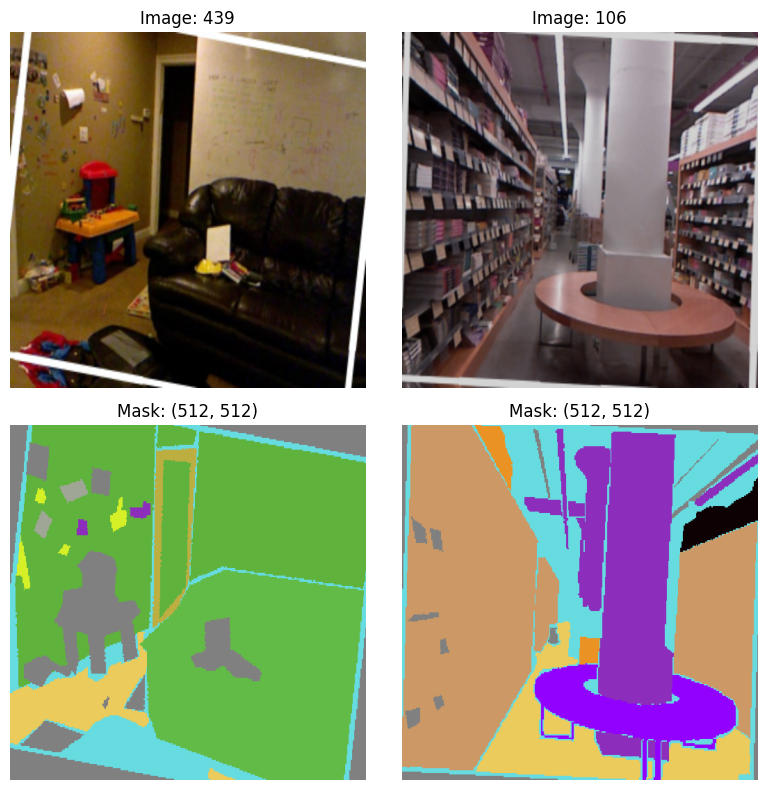

In [63]:
# Create data loaders
train_loader, val_loader, test_loader, processor = create_data_loaders(config)

# Test data loading and visualization
print("\\n🧪 Testing data loading...")
sample_batch = next(iter(train_loader))
print(f"✅ Batch loaded successfully!")
print(f"📏 pixel_values shape: {sample_batch['pixel_values'].shape}")
print(f"📏 labels shape: {sample_batch['labels'].shape}")
print(f"🏷️ Sample IDs: {sample_batch['id'][:3]}")

# Visualize samples (uncomment to see)
visualize_batch(sample_batch, processor, num_samples=2)

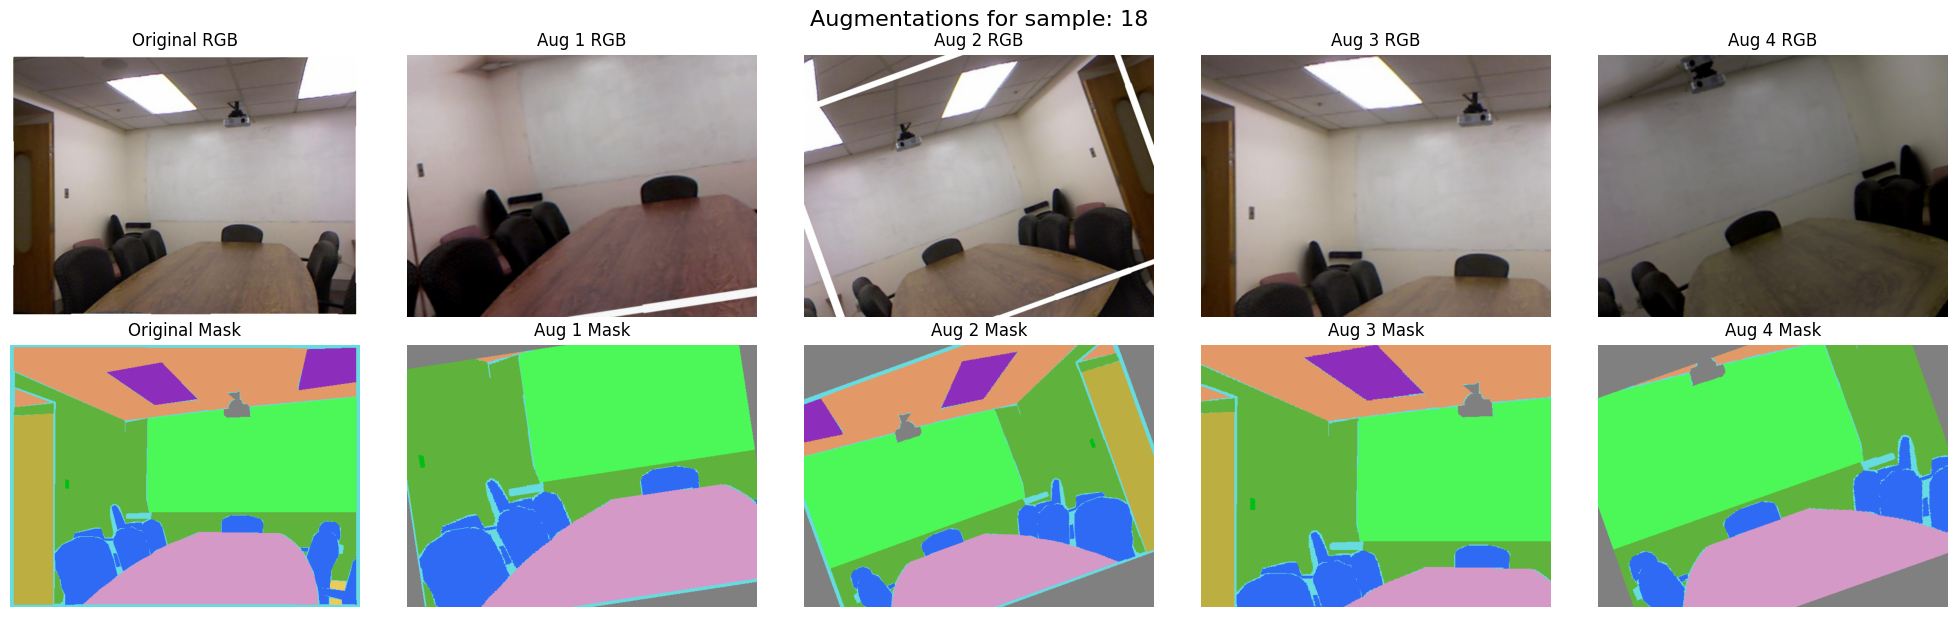

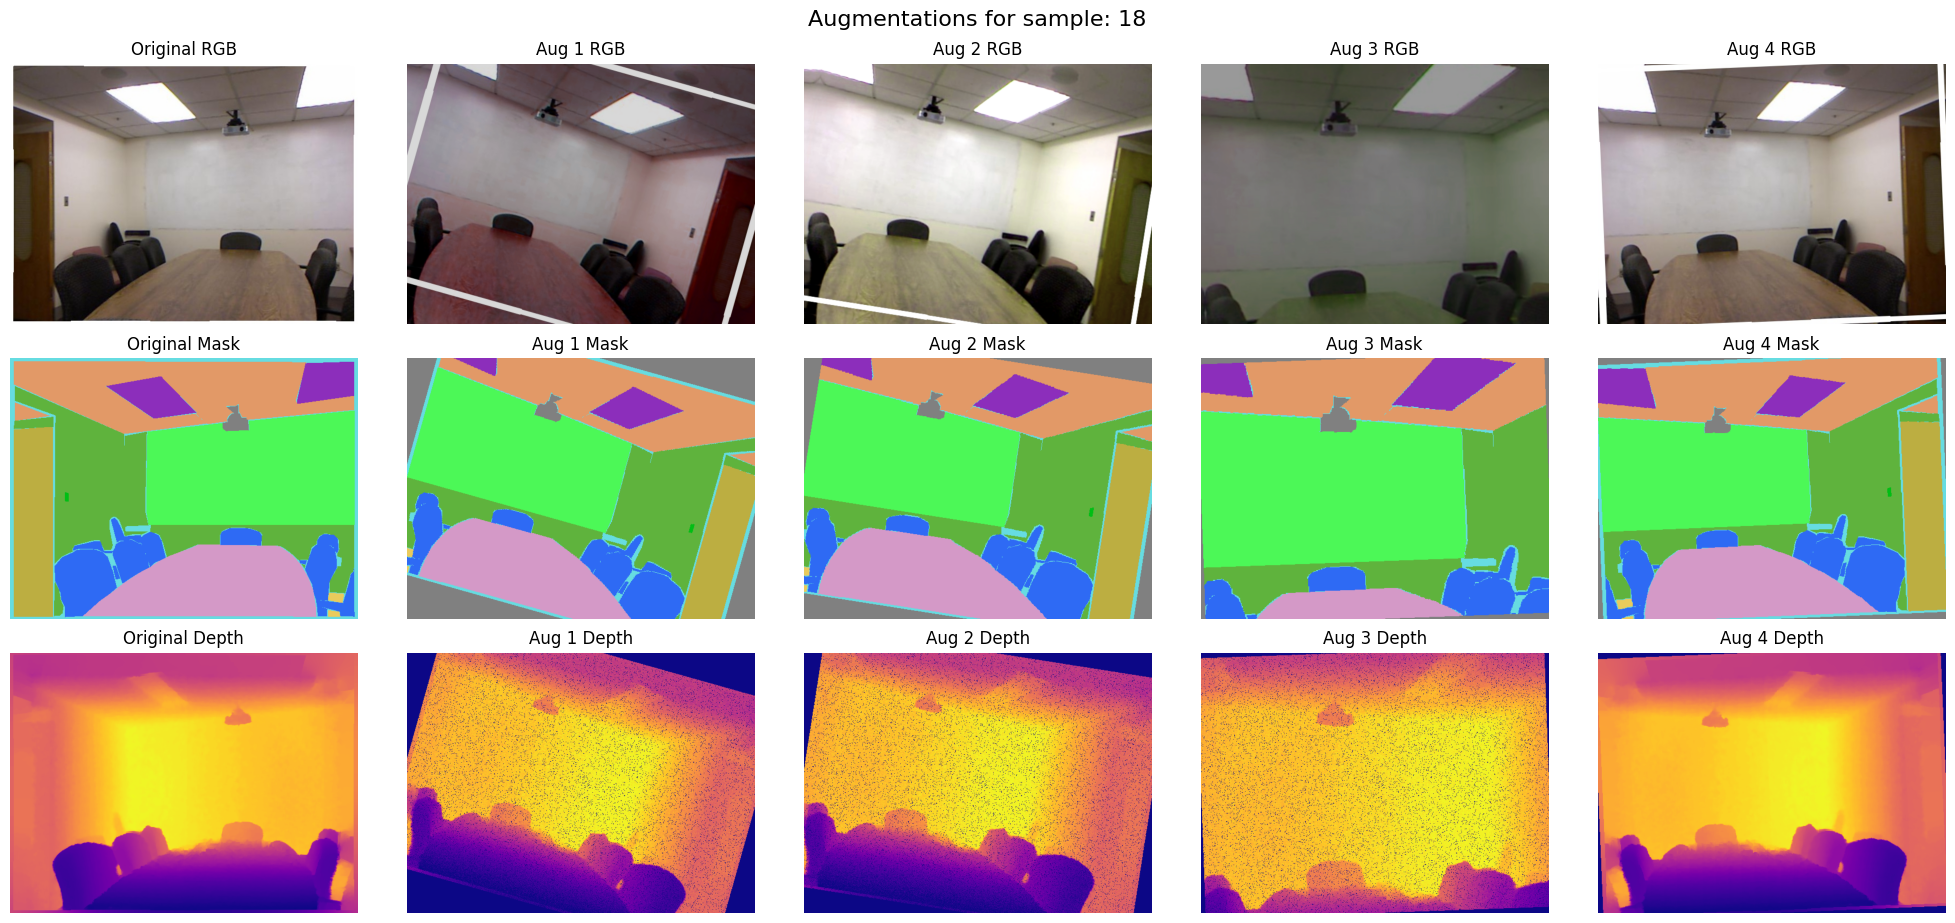

In [66]:
show_augmentations(train_loader.dataset, sample_idx=10, num_augmentations=4, use_depth=False)
show_augmentations(train_loader.dataset, sample_idx=10, num_augmentations=4, use_depth=True)